### Cell 1: Install Libraries

This cell uses `pip install -q` to quietly install required Python libraries. Key packages are:

* **pandas, numpy, matplotlib, seaborn:** Standard data manipulation and visualization.
* **scikit-learn:** For ML tasks (TF-IDF, clustering, evaluation).
* **sentence-transformers:** Generates dense MiniLM text embeddings.
* **bertopic, hdbscan:** Used for topic modeling and HDBSCAN clustering.
* **spacy:** NLP library used here for NER (location identification).
* **transformers[torch]:** Hugging Face library for pre-trained models.
* **spacy download en\_core\_web\_sm:** Downloads the small English spaCy model with NER.




In [ ]:
# Use pip to install required packages quietly (-q)
!pip -q install --upgrade pandas numpy matplotlib seaborn scikit-learn \
                       sentence_transformers bertopic hdbscan spacy transformers[torch]
# Download the small English language model for spaCy (includes NER)
!python -m spacy download en_core_web_sm -q



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Cell 2: Imports and Setup

This cell imports the installed libraries and performs initial setup.

* Standard libraries like `pandas`, `numpy`, `matplotlib.pyplot`, `seaborn`, `re` (regular expressions), `time`, and `warnings` are imported with common aliases.
* `pathlib.Path` is imported for potential file path manipulation (though not used in the provided snippet).
* `torch` is imported to check for GPU availability.
* `seaborn.set_theme` configures the visual style of plots.
* `warnings.filterwarnings("ignore")` suppresses warning messages for cleaner output.
* A hardware check determines if a CUDA-enabled GPU is available (`torch.cuda.is_available()`) and sets the `DEVICE` variable accordingly ('cuda' or 'cpu'). This is crucial for accelerating model computations (like sentence embeddings) if a GPU is present.


In [ ]:
# --- Imports --------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re                         # Regular expression operations
import time                       # Time-related functions (e.g., measuring execution time)
import warnings                   # Warning message control
from pathlib import Path          # Object-oriented filesystem paths (optional here)
import torch

# Set the default theme for seaborn plots
sns.set_theme(style="whitegrid")
# Ignore warning messages during execution
warnings.filterwarnings("ignore")

# --- Hardware check ------------------------------------------
# Check if a CUDA-compatible GPU is available for faster processing
GPU = torch.cuda.is_available()
# Set the device for PyTorch models: 'cuda' if GPU is available, otherwise 'cpu'
DEVICE = "cuda" if GPU else "cpu"

# Print device status
print(f"GPU Available: {GPU}")
print(f"Using Device: {DEVICE}")



GPU Available: False
Using Device: cpu


### Cell 3: Experiment Toggles (Flags)

This cell defines a dictionary called `FLAGS`. These flags act as switches to easily enable or disable different parts of the analysis pipeline without modifying the main code logic. This is useful for experimenting with different filtering or clustering techniques.

* `use_spacy_ner`: If `True`, apply spaCy NER filtering to keep only headlines mentioning geographical locations (GPE) or general locations (LOC).
* `use_minilm_cos`: If `True`, apply semantic filtering using Sentence Transformers (MiniLM model) and cosine similarity to keep headlines semantically similar to predefined "anchor" sentences about natural disasters.
* `use_nli_clean`: If `True` (currently `False`), apply a zero-shot Natural Language Inference (NLI) model (like BART) for filtering. *Note: This step is disabled in the current configuration.*
* `run_agglo`, `run_spectral`, `run_hdbscan`: If `True`, run the respective clustering algorithms (Agglomerative, Spectral, HDBSCAN).
* `run_supervised`: If `True` (currently `True`), run a pseudo-supervised logistic regression model.


In [ ]:
#**************************************************************
#  EXPERIMENT TOGGLES
#  Flip True ⇆ False to include / skip each step.
#  Results update automatically in summary tables.
#**************************************************************

# Dictionary to hold boolean flags controlling execution flow
FLAGS = dict(
    use_spacy_ner = True,   # Enable/disable spaCy GPE/LOC named entity recognition filter
    use_minilm_cos= True,   # Enable/disable semantic cosine similarity filter using MiniLM
    use_nli_clean = False,  # Enable/disable zero-shot BART NLI filter (currently off)
    run_agglo     = True,   # Enable/disable Agglomerative clustering
    run_spectral  = True,   # Enable/disable Spectral clustering
    run_hdbscan   = True,   # Enable/disable HDBSCAN clustering
    run_supervised= True,   # Enable/disable pseudo-supervised Logistic Regression (code may be missing later)
)

# Print the flags to confirm settings
print("Experiment Flags:", FLAGS)



Experiment Flags: {'use_spacy_ner': True, 'use_minilm_cos': True, 'use_nli_clean': False, 'run_agglo': True, 'run_spectral': True, 'run_hdbscan': True, 'run_supervised': True}


### Cell 4: Load Data

This cell loads the dataset from the specified CSV file into a pandas DataFrame.

* `CSV_PATH`: Defines the path to the input CSV file. *Make sure this path is correct for your Colab environment (e.g., uploaded file or Google Drive mount).*
* `pd.read_csv`: Reads the data from the CSV file. `encoding="utf-8"` is specified to handle a wide range of characters correctly.
* The code then prints the number of rows and the list of column names found in the loaded DataFrame.


In [ ]:

# Define the path to the dataset CSV file
CSV_PATH = "/content/Nat Cat Events.csv" # Make sure this path is correct in your environment!

# Read the CSV file into a pandas DataFrame, specifying UTF-8 encoding
raw = pd.read_csv(CSV_PATH, encoding="utf-8")

# Print the dimensions (rows) and column names of the loaded DataFrame
print(f"Rows: {len(raw):,}   •   Columns: {list(raw.columns)}")



Rows: 91,479   •   Columns: ['url', 'url_mobile', 'title', 'seendate', 'socialimage', 'domain', 'language', 'sourcecountry']


### Cell 5: Initial Exploratory Data Analysis (EDA)

This cell performs a basic EDA on the loaded data, similar to the steps discussed previously.

* `raw.info(verbose=False)`: Displays concise information about the DataFrame, including column names, non-null counts, and data types, omitting detailed index/memory info.
* `(raw.isna().mean()*100).sort_values().plot.barh(...)`: Calculates the percentage of missing values for each column, sorts them, and creates a horizontal bar plot to visualize missingness. `plt.tight_layout()` adjusts plot parameters for a tight layout.
* `raw["title_len"] = raw["title"].astype(str).str.len()`: Creates a new column `title_len` containing the character length of each headline in the `title` column. `astype(str)` handles potential non-string values (like NaN).
* `print(...)`: Prints basic statistics (minimum, median, maximum) for the headline lengths.
* `raw["title_len"].hist(...)`: Generates a histogram to visualize the distribution of headline lengths.
* `raw["pub_date"] = pd.to_datetime(...)`: Converts the `seendate` column (assumed to be in 'YYYYMMDDTHHMMSSZ' format) into datetime objects, creating a new `pub_date` column. `errors="coerce"` turns parsing errors into `NaT` (Not a Time).
* `print(...)`: Prints the minimum and maximum dates found in the `pub_date` column, showing the time span of the dataset.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91479 entries, 0 to 91478
Columns: 10 entries, url to pub_date
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 7.0+ MB


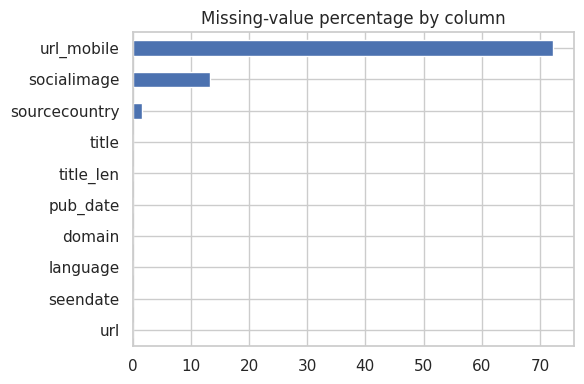


Length stats: {'min': 3.0, '50%': 68.0, 'max': 253.0}


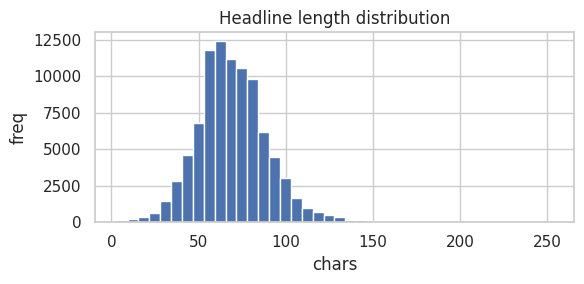

Date span → 2024-01-01 00:00:00 → 2025-01-01 00:15:00


In [17]:
# Display concise summary information about the DataFrame (columns, non-nulls, dtypes)
raw.info(verbose=False)

# Calculate the percentage of missing values per column
missing_percentage = (raw.isna().mean() * 100)

# Sort the missing percentages and create a horizontal bar plot
missing_percentage.sort_values().plot.barh(figsize=(6, 4),
                                           title="Missing-value percentage by column")
plt.tight_layout() # Adjust plot layout
plt.show()         # Display the plot

# --- Headline length stats -----------------------------------
# Calculate the length of each title (convert to string first to handle potential NaNs)
raw["title_len"] = raw["title"].astype(str).str.len()

# Print descriptive statistics for title length (min, median, max)
print("\nLength stats:", raw["title_len"].describe()[["min", "50%", "max"]].to_dict())

# Plot a histogram of title lengths
raw["title_len"].hist(bins=40, figsize=(6, 3))
plt.title("Headline length distribution")
plt.xlabel("chars")
plt.ylabel("freq")
plt.tight_layout() # Adjust plot layout
plt.show()         # Display the plot

# --- Publication date range ----------------------------------
# Convert the 'seendate' column to datetime objects
# Assumes format like '20230101T100000Z'
# errors='coerce' will turn unparseable dates into NaT (Not a Time)
raw["pub_date"] = pd.to_datetime(raw["seendate"], errors="coerce",
                                 format="%Y%m%dT%H%M%SZ")

# Print the minimum and maximum publication dates found in the data
print("Date span →", raw["pub_date"].min(), "→", raw["pub_date"].max())

### Cell 6: Text Cleaning Setup - spaCy and Regex

This cell sets up tools for cleaning and filtering the text data (headlines).

* `spacy.load(...)`: Loads the previously downloaded `en_core_web_sm` spaCy model. `disable=["parser", "tagger"]` disables components not needed for NER, potentially saving memory and speeding up processing. The loaded model is assigned to `nlp`.
* `HAZARDS`: A list of keywords related to natural catastrophe events.
* `EVENT_RE`: A compiled regular expression to find any whole word from the `HAZARDS` list within a text, ignoring case (`re.I`). `re.escape` handles special characters in keywords. `\b` ensures matching whole words.
* `PAST_RE`: A compiled regex to find common past-tense verbs or words indicating a past event (e.g., "struck", "hit", "caused", "reported"), ignoring case. This helps filter for headlines reporting on events that have occurred.
* `LOC_RE`: A compiled regex attempting to identify location mentions. It looks for patterns like "in/near/of/over/involving" followed by a capitalized word, or sequences of two or more uppercase letters (like acronyms or country codes). This is a heuristic approach.
* `BAD_RE`: A compiled regex to identify specific phrases or topics that are likely *not* relevant natural catastrophe reports (e.g., "taylor swift", "universal resort"), ignoring case. This helps filter out noise.
* `basic_clean(text)`: Defines a function to perform simple text cleaning:
    * Collapses multiple whitespace characters into single spaces.
    * Removes characters that are *not* letters, numbers, whitespace, hyphens, periods, colons, or forward slashes.
    * Removes leading/trailing whitespace.




In [ ]:
import spacy # Import the spaCy library
import re    # Import the regular expression library

# Load the small English spaCy model, disabling unnecessary components (parser, tagger)
# to save memory and potentially speed up processing for NER.
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger"])

# --- keyword lists -------------------------------------------
# Define a list of keywords related to natural hazards
HAZARDS = ["earthquake", "aftershock", "flood", "wildfire", "bushfire", "forest fire",
           "hurricane", "cyclone", "typhoon", "tornado", "waterspout", "volcano",
           "eruption", "landslide", "mudslide", "avalanche", "tsunami", "tidal wave",
           "storm", "thunderstorm", "blizzard", "snowstorm", "heatwave", "heat wave", "drought"]

# --- Regular Expressions for Filtering ---
# Compile a regex to find any hazard keyword (case-insensitive, whole word)
EVENT_RE = re.compile(rf"\b({'|'.join(map(re.escape, HAZARDS))})\b", re.I)
# Compile a regex to find past-tense verbs or event indicators (case-insensitive, whole word)
PAST_RE  = re.compile(r"\b(has|have|had|was|were|struck|hit|erupted|reported|"
                      r"identified|caused|sparked|flooded|damaged|killed|"
                      r"injured|collapsed)\b", re.I)
# Compile a regex to heuristically find location mentions (case-insensitive for prepositions)
# Looks for patterns like 'in CityName' or 'USA'
LOC_RE   = re.compile(r"\b(?:in|near|of|over|involving)\s+[A-Z][a-z]+|\b[A-Z]{2,}\b", re.I)
# Compile a regex to find irrelevant phrases to filter out (case-insensitive)
BAD_RE   = re.compile(r"taylor swift|universal resort|recruiting efforts|"
                      r"staying dry|chilly night", re.I)

# --- Cleaning Function ---
def basic_clean(text: str) -> str:
    """Whitespace collapse & soft punctuation strip (keeps - . : /)."""
    # Replace multiple whitespace characters with a single space
    text = re.sub(r"\s+", " ", str(text))
    # Remove characters that are NOT letters, numbers, whitespace, or specific punctuation (-.:/)
    text = re.sub(r"[^A-Za-z0-9\s\-\.:/]", "", text).strip()
    # Return the cleaned and stripped text
    return text


### Cell 7: Apply Basic Cleaning and Initial Filtering

This cell applies the cleaning function and performs the initial filtering based on the regular expressions defined previously.

* `df = raw.dropna(subset=["title"]).copy()`: Creates a copy (`df`) of the original DataFrame (`raw`), dropping rows where the `title` is missing (NaN).
* `df["clean_title"] = df["title"].map(basic_clean)`: Applies the `basic_clean` function to each title and stores the result in a new `clean_title` column.
* `df = df.drop_duplicates(subset=["clean_title"])`: Removes duplicate rows based on the `clean_title` column, keeping only the first occurrence.
* `mask_base`: Creates a boolean mask based on several conditions applied to `clean_title`:
    * Must contain a hazard keyword (`EVENT_RE`).
    * Must contain a potential location mention (`LOC_RE`).
    * Must contain a past-tense/event indicator (`PAST_RE`).
    * Must *not* contain any irrelevant phrases (`BAD_RE`).
* `clean = df[mask_base].reset_index(drop=True)`: Applies the `mask_base` to filter the DataFrame `df`, keeping only rows where all conditions are `True`. `reset_index(drop=True)` resets the index of the resulting DataFrame.
* `log = [("baseline", len(clean))]`: Initializes a list `log` to keep track of the number of rows remaining after each filtering stage.
* `print(...)`: Prints the number and percentage of rows kept after this baseline filtering.




In [ ]:

# Create a copy of the raw DataFrame, dropping rows with missing titles
df = raw.dropna(subset=["title"]).copy()

# Apply the basic_clean function to the 'title' column and store in 'clean_title'
df["clean_title"] = df["title"].map(basic_clean)

# Remove duplicate rows based on the cleaned title content
df = df.drop_duplicates(subset=["clean_title"])

# --- Baseline Filtering using Regex ---
# Create a boolean mask based on multiple regex conditions:
mask_base = (
    df["clean_title"].str.contains(EVENT_RE)   # Must contain a hazard keyword
    & df["clean_title"].str.contains(LOC_RE)    # Must contain a potential location
    & df["clean_title"].str.contains(PAST_RE)   # Must contain a past-tense indicator
    & ~df["clean_title"].str.contains(BAD_RE)   # Must NOT contain irrelevant phrases
)

# Apply the mask to filter the DataFrame
clean = df[mask_base].reset_index(drop=True) # Reset index for the filtered DataFrame

# Initialize a log to track row counts after filtering steps
log = [("baseline", len(clean))]

# Print the number of rows remaining after baseline filtering and the percentage
print(f"Baseline keep → {len(clean):,} rows "
      f"({len(clean)/len(df):.2%} of de-duped set)")


Baseline keep → 5,268 rows (8.09% of de-duped set)


### Cell 8: spaCy NER Filtering (Conditional)

This cell applies an additional filtering step using spaCy's Named Entity Recognition (NER), but only if the corresponding flag (`FLAGS["use_spacy_ner"]`) is set to `True`.

* `if FLAGS["use_spacy_ner"]:`: Checks the flag.
* `t0=time.time()`: Records the start time for performance measurement.
* `ner_mask = clean["clean_title"].apply(...)`: Applies a lambda function to each `clean_title`.
    * `nlp(t)`: Processes the title `t` using the loaded spaCy model (`nlp`).
    * `nlp(t).ents`: Accesses the named entities recognized by spaCy in the title.
    * `any(e.label_ in {"GPE", "LOC"} for e in ...)`: Checks if *any* recognized entity (`e`) has a label that is either 'GPE' (Geopolitical Entity, e.g., countries, cities) or 'LOC' (Location, e.g., mountains, rivers).
    * The result is a boolean mask (`ner_mask`) indicating which titles contain a GPE or LOC entity.
* `clean = clean[ner_mask].reset_index(drop=True)`: Applies the `ner_mask` to further filter the `clean` DataFrame.
* `log.append(...)`: Adds the row count after this stage to the log.
* `print(...)`: Prints the number of rows removed by this filter and the time taken.




In [ ]:
# --- spaCy NER Filtering (Optional) ---
# Check if the spaCy NER filtering flag is enabled
if FLAGS["use_spacy_ner"]:
    print("\nApplying spaCy NER filter...")
    t0 = time.time() # Record start time

    # Create a mask by checking if any named entity in the title is a GPE or LOC
    # This uses the spaCy model loaded earlier ('nlp')
    ner_mask = clean["clean_title"].apply(
        lambda t: any(entity.label_ in {"GPE", "LOC"} for entity in nlp(t).ents)
    )

    # Apply the NER mask to the 'clean' DataFrame
    rows_before_ner = len(clean)
    clean = clean[ner_mask].reset_index(drop=True) # Filter and reset index

    # Log the number of rows remaining
    log.append(("spaCy_NER", len(clean)))

    # Print the number of rows dropped and the time taken
    print(f"spaCy NER filter ↓ {rows_before_ner - len(clean):,} rows   "
          f"time: {round(time.time() - t0, 1)}s")
    print(f"Rows remaining after spaCy NER: {len(clean):,}")
else:
    print("\nSkipping spaCy NER filter (flag is False).")




Applying spaCy NER filter...
spaCy NER filter ↓ 1,918 rows   time: 39.6s
Rows remaining after spaCy NER: 3,350


### Cell 9: MiniLM Cosine Similarity Filtering (Conditional)

This cell applies semantic filtering using sentence embeddings and cosine similarity, but only if `FLAGS["use_minilm_cos"]` is `True`. The goal is to keep headlines that are semantically similar to predefined "anchor" sentences describing typical natural catastrophe events.

* `if FLAGS["use_minilm_cos"]:`: Checks the flag.
* `from sentence_transformers import SentenceTransformer, util`: Imports necessary components.
* `anchors`: Defines a list of simple sentences representing core natural disaster events.
* `sbert = SentenceTransformer(...)`: Loads the `all-MiniLM-L6-v2` model from `sentence-transformers`. This model is efficient and good at generating general-purpose sentence embeddings. `device=DEVICE` ensures it uses the GPU if available.
* `emb_titles = sbert.encode(...)`: Encodes all `clean_title` entries into dense vector embeddings. `batch_size` improves efficiency; `show_progress_bar=False` hides the progress bar for this step.
* `emb_anchors = sbert.encode(...)`: Encodes the `anchors` list into embeddings.
* `sims = util.cos_sim(emb_titles, emb_anchors)`: Calculates the cosine similarity between *each* title embedding and *each* anchor embedding. The result `sims` is a matrix where `sims[i, j]` is the similarity between title `i` and anchor `j`.
* `scores = sims.max(dim=1).values`: For each title, finds the *maximum* similarity score it has with *any* of the anchors.
* `mask = (scores > 0.45).cpu().numpy()`: Creates a boolean mask, keeping titles where the maximum similarity score to any anchor is greater than 0.45 (a threshold chosen empirically). `.cpu().numpy()` converts the result back to a NumPy array on the CPU.
* `clean = clean.loc[mask].reset_index(drop=True)`: Applies the semantic similarity mask to filter the DataFrame.
* `log.append(...)`: Adds the row count after this stage to the log.
* `print(...)`: Prints the number of rows removed by this filter.


In [ ]:
# --- MiniLM Cosine Similarity Filtering (Optional) ---
# Check if the MiniLM cosine similarity filtering flag is enabled
if FLAGS["use_minilm_cos"]:
    print("\nApplying MiniLM Cosine Similarity filter...")
    t0 = time.time() # Record start time
    # Import necessary classes from sentence_transformers
    from sentence_transformers import SentenceTransformer, util

    # 1. Define your semantic “anchor” sentences representing typical events
    anchors = [
        "An earthquake struck the region",
        "Severe floods hit the city",
        "Wildfire burned thousands of acres",
        "A tornado touched down",
        "A volcano erupted near the town"
    ]

    # 2. Load the pre-trained Sentence Transformer model (using GPU if available)
    # 'all-MiniLM-L6-v2' is a popular choice for good performance and speed
    sbert = SentenceTransformer("all-MiniLM-L6-v2", device=DEVICE)

    # 3. Encode the cleaned titles and anchor sentences into vector embeddings
    print("Encoding titles...")
    emb_titles  = sbert.encode(clean["clean_title"].tolist(),
                               batch_size=256,       # Process in batches for efficiency
                               show_progress_bar=True) # Show progress
    print("Encoding anchors...")
    emb_anchors = sbert.encode(anchors,
                               batch_size=len(anchors), # Process all anchors at once
                               show_progress_bar=False)

    # 4. Calculate cosine similarity between each title embedding and all anchor embeddings
    print("Calculating similarities...")
    sims = util.cos_sim(emb_titles, emb_anchors)

    # 5. For each title, find the maximum similarity score against any anchor
    scores = sims.max(dim=1).values # Get the max similarity score for each row (title)

    # 6. Create a mask based on a similarity threshold (e.g., > 0.45)
    # Titles with a max similarity below this threshold are considered less relevant
    SIMILARITY_THRESHOLD = 0.45
    mask = (scores > SIMILARITY_THRESHOLD).cpu().numpy() # Convert to numpy array on CPU

    # 7. Apply the mask to filter the DataFrame
    rows_before_minilm = len(clean)
    clean = clean.loc[mask].reset_index(drop=True) # Filter and reset index

    # 8. Log the number of rows remaining
    log.append(("MiniLM_cosine", len(clean)))

    # 9. Print the number of rows dropped and time taken
    print(f"MiniLM filter (threshold > {SIMILARITY_THRESHOLD}) ↓ {rows_before_minilm - len(clean):,} rows   "
          f"time: {round(time.time() - t0, 1)}s")
    print(f"Rows remaining after MiniLM filter: {len(clean):,}")

    # Optional: Clean up large variables if memory is a concern
    # del emb_titles, emb_anchors, sims, scores
else:
    print("\nSkipping MiniLM Cosine Similarity filter (flag is False).")




Applying MiniLM Cosine Similarity filter...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding titles...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Encoding anchors...
Calculating similarities...
MiniLM filter (threshold > 0.45) ↓ 481 rows   time: 72.0s
Rows remaining after MiniLM filter: 2,869


### Cell 10: Display Filtering Log Summary

This cell displays a summary table showing the number of rows remaining after each filtering stage applied so far, using the `log` list populated in previous steps. The table quantifies the impact of each filter. Based on the provided results, the output indicates:
* Starting with 5,268 relevant rows after baseline regex filtering.
* Reduced to 3,350 rows after spaCy NER filtering (a drop of 1,918).
* Further reduced to 2,869 rows after MiniLM cosine similarity filtering (an additional drop of 481).

The code works as follows:
* `pd.DataFrame(log, ...)`: Creates a DataFrame from the `log` list (stage name, row count tuples).
* `.assign(Δ=lambda d: ...)`: Adds a 'Δ' (Delta) column showing the change in rows from the previous stage, calculated using `.diff()` and formatted as an integer.





In [ ]:
# --- Filtering Log Summary ---
print("\n--- Filtering Stages Summary ---")
# Create a DataFrame from the log list
df_log = pd.DataFrame(log, columns=["Stage", "Rows"])

# Calculate the change (delta) in rows between consecutive stages
df_log = df_log.assign(
    Δ=lambda d: d["Rows"].diff().fillna(0).astype(int)
)

# Display the summary DataFrame
print(df_log)



--- Filtering Stages Summary ---
           Stage  Rows     Δ
0       baseline  5268     0
1      spaCy_NER  3350 -1918
2  MiniLM_cosine  2869  -481


### Cell 11: TF-IDF Vectorization

This cell converts the cleaned headlines into a numerical format using TF-IDF (Term Frequency-Inverse Document Frequency). This representation considers word importance based on frequency within a document and across the entire corpus.

* `from sklearn.feature_extraction.text import TfidfVectorizer`: Imports the vectorizer.
* `tfidf = TfidfVectorizer(...)`: Initializes the TF-IDF vectorizer with specific parameters:
    * `ngram_range=(1, 2)`: Considers both single words (uni-grams) and pairs of adjacent words (bi-grams) as features. This captures more context than uni-grams alone.
    * `min_df=3`: Ignores terms that appear in fewer than 3 documents (headlines). This helps remove rare words or potential typos.
    * `stop_words="english"`: Removes common English stop words (like "the", "a", "is") using scikit-learn's built-in list.
* `X_tfidf = tfidf.fit_transform(clean["clean_title"])`: Fits the vectorizer to the `clean_title` data (learning the vocabulary and IDF weights) and then transforms the titles into a sparse TF-IDF matrix `X_tfidf`. Each row corresponds to a headline, and each column corresponds to a unique uni-gram or bi-gram feature.




In [ ]:
# --- Feature Engineering: TF-IDF Vectorization ---
print("\n--- Generating TF-IDF Features ---")
# Import the TF-IDF vectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),    # Include both single words (unigrams) and pairs (bigrams)
    min_df=3,              # Ignore terms that appear in less than 3 documents
    stop_words="english"   # Remove common English stop words
)

# Fit the vectorizer to the cleaned titles and transform them into a TF-IDF matrix
# The result X_tfidf is a sparse matrix where rows are documents and columns are features (n-grams)
X_tfidf = tfidf.fit_transform(clean["clean_title"])

# Print the shape of the resulting TF-IDF matrix (documents, features)
print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")




--- Generating TF-IDF Features ---
TF-IDF Matrix Shape: (2869, 1838)



### Cell 12: Sentence Transformer (MiniLM) Embedding

This cell generates dense vector embeddings for the cleaned headlines using the pre-trained Sentence Transformer model (`all-MiniLM-L6-v2`). Unlike sparse TF-IDF vectors, these dense embeddings capture semantic meaning, where similar headlines have vectors closer together in the embedding space.

* `if "sbert" not in globals():`: Checks if the `sbert` model object (created during the optional cosine similarity filtering step) already exists. This avoids reloading the model unnecessarily if the previous step was run.
* `from sentence_transformers import SentenceTransformer`: Imports the class if needed.
* `sbert = SentenceTransformer(...)`: Loads the model if it doesn't exist.
* `X_emb = sbert.encode(...)`: Encodes the `clean_title` entries into dense embeddings (`X_emb`). `batch_size` is used for efficiency, and `show_progress_bar=True` displays progress. `X_emb` will be a NumPy array where each row is a fixed-size dense vector representing a headline.




In [ ]:
# --- Feature Engineering: Sentence Embeddings (MiniLM) ---
print("\n--- Generating Sentence Embeddings (MiniLM) ---")

# Check if the Sentence Transformer model ('sbert') was already loaded
# (e.g., during the cosine similarity filtering step) to avoid reloading.
if "sbert" not in globals():
    print("Loading Sentence Transformer model...")
    # Import the class if it wasn't imported before
    from sentence_transformers import SentenceTransformer
    # Load the model, specifying the device (GPU or CPU)
    sbert = SentenceTransformer("all-MiniLM-L6-v2", device=DEVICE)
else:
    print("Using existing Sentence Transformer model.")

# Encode the cleaned titles into dense vector embeddings using the loaded model
# X_emb will be a numpy array where each row is an embedding vector for a title
X_emb = sbert.encode(clean["clean_title"].tolist(),
                     batch_size=256,        # Process in batches
                     show_progress_bar=True) # Show encoding progress

# Print the shape of the resulting embedding matrix (documents, embedding_dimension)
print(f"Sentence Embedding Matrix Shape: {X_emb.shape}")




--- Generating Sentence Embeddings (MiniLM) ---
Using existing Sentence Transformer model.


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Sentence Embedding Matrix Shape: (2869, 384)


In [30]:
#silhoute test
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#1)k means on tf-idf
km_tfidf = KMeans(n_clusters=5, random_state=42, n_init="auto").fit(X_tfidf)
labels_tfidf = km_tfidf.labels_
sil_tfidf = silhouette_score(X_tfidf, labels_tfidf)
print(f"Silhouette (TF‑IDF, k=5): {sil_tfidf:.3f}")
# 2) K‑Means on MiniLM embeddings
km_emb = KMeans(n_clusters=5, random_state=42, n_init="auto").fit(X_emb)
labels_emb = km_emb.labels_
sil_emb = silhouette_score(X_emb, labels_emb)
print(f"Silhouette (MiniLM, k=5): {sil_emb:.3f}")


Silhouette (TF‑IDF, k=5): 0.053
Silhouette (MiniLM, k=5): 0.145


### Cell 13: K-Means Elbow Method (TF-IDF)

This cell uses the Elbow Method to help determine a suitable number of clusters (`k`) for the K-Means algorithm when applied to the TF-IDF vectors.
* `from sklearn.cluster import KMeans`: Imports the K-Means clustering algorithm.
* `WCSS = []`: Initializes an empty list to store the Within-Cluster Sum of Squares (WCSS) for different values of `k`. WCSS (also called inertia) measures the sum of squared distances of samples to their closest cluster center. Lower WCSS generally indicates tighter clusters.
* `for k in range(2, 11):`: Loops through potential cluster numbers from 2 to 10.
* `KMeans(k, n_init="auto", random_state=42)`: Initializes K-Means for the current `k`. `n_init="auto"` runs the algorithm multiple times with different centroid seeds and chooses the best result (recommended). `random_state` ensures reproducibility.
* `.fit(X_tfidf)`: Fits the K-Means model to the TF-IDF data.
* `.inertia_`: Retrieves the WCSS (inertia) for the fitted model.
* `WCSS.append(...)`: Appends the calculated WCSS to the list.
* `plt.plot(...)`: Plots the WCSS values against the corresponding `k` values.
* The "elbow" point on the plot (where the rate of decrease in WCSS slows down significantly) is often considered a good indicator of a suitable `k`.

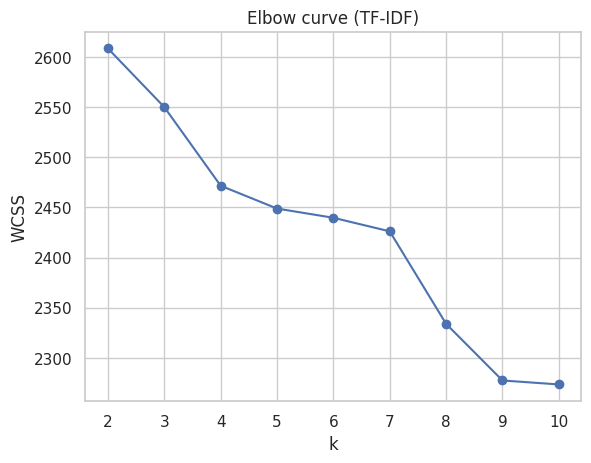

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for k in range(2,11):
    wcss.append(KMeans(n_clusters=k, random_state=42, n_init="auto")
                .fit(X_tfidf).inertia_)
plt.plot(range(2,11), wcss, marker="o")
plt.xlabel("k"); plt.ylabel("WCSS")
plt.title("Elbow curve (TF‑IDF)"); plt.show()


CELL 14:
This code tunes hyperparameters for various clustering algorithms using MiniLM embeddings (X_emb) and TF-IDF features (X_tfidf), then evaluates the tuned models.

Key Steps:

Imports: Imports clustering algorithms (KMeans, etc.), evaluation metrics (silhouette_score, etc.), and helpers (pandas, sparse).

Tune K-Means k (on MiniLM Embeddings): Tunes k (testing 5, 6) on MiniLM embeddings (X_emb) using Silhouette Score to find best_k_emb.

Tune Agglomerative Clustering linkage: Tunes linkage ('ward', etc.) on X_emb (using best_k_emb) via Silhouette Score to find best_link.

Tune Spectral Clustering affinity: Tunes affinity ('rbf', 'nearest_neighbors') on X_emb (using best_k_emb) via Silhouette Score to find best_aff.

Tune HDBSCAN min_cluster_size: Tunes min_cluster_size on X_emb using Silhouette Score on core points (label != -1) to find best_size.

Define Evaluation Helper (evaluate function): Defines evaluate function to calculate Silhouette (higher is better) and Davies-Bouldin (lower is better) scores, handling sparse/dense inputs.

Final Model Evaluation: Fits final models using tuned hyperparameters (K-Means on X_emb/X_tfidf, Agglomerative, Spectral, HDBSCAN). Calculates final scores using evaluate (HDBSCAN on core points only) and stores results.

Display Comparison Table: Creates and prints a comparison DataFrame (df_results) sorted by Silhouette Score.

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# Full Clustering Block: Tuning & Final Evaluation
# ───────────────────────────────────────────────────────────────────────────────

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import hdbscan
from scipy import sparse
import pandas as pd

# 1️⃣ Tune k for MiniLM embeddings (only k=5 and k=6 from elbow)
sil_scores_emb = {}
for k in [5, 6]:
    labels = KMeans(n_clusters=k, random_state=42, n_init="auto") \
                .fit(X_emb).labels_
    sil = silhouette_score(X_emb, labels)
    sil_scores_emb[k] = sil
    print(f"Silhouette (MiniLM embeddings, k={k}): {sil:.3f}")
best_k_emb = max(sil_scores_emb, key=sil_scores_emb.get)
print(f"\n👉 Best k in embedding space: {best_k_emb} (silhouette={sil_scores_emb[best_k_emb]:.3f})\n")

# 2️⃣ Tune Agglomerative linkage
best_link, best_link_sil = None, -1.0
for link in ["ward", "complete", "average"]:
    labels = AgglomerativeClustering(
        n_clusters=best_k_emb, linkage=link
    ).fit_predict(X_emb)
    sil = silhouette_score(X_emb, labels)
    print(f"Agglomerative linkage='{link}': silhouette={sil:.3f}")
    if sil > best_link_sil:
        best_link, best_link_sil = link, sil
print(f"\n👉 Best Agglomerative linkage: {best_link} (silhouette={best_link_sil:.3f})\n")

# 3️⃣ Tune Spectral affinity
best_aff, best_aff_sil = None, -1.0
for aff in ["rbf", "nearest_neighbors"]:
    labels = SpectralClustering(
        n_clusters=best_k_emb, affinity=aff, assign_labels="kmeans",
        random_state=42
    ).fit_predict(X_emb)
    sil = silhouette_score(X_emb, labels)
    print(f"Spectral affinity='{aff}': silhouette={sil:.3f}")
    if sil > best_aff_sil:
        best_aff, best_aff_sil = aff, sil
print(f"\n👉 Best Spectral affinity: {best_aff} (silhouette={best_aff_sil:.3f})\n")

# 4️⃣ Tune HDBSCAN min_cluster_size
best_size, best_size_sil = None, -1.0
for size in [20, 40, 60, 80]:
    hb = hdbscan.HDBSCAN(min_cluster_size=size).fit(X_emb)
    mask = hb.labels_ != -1
    if mask.sum() > 0:
        sil = silhouette_score(X_emb[mask], hb.labels_[mask])
        print(f"HDBSCAN size={size}: silhouette={sil:.3f}")
        if sil > best_size_sil:
            best_size, best_size_sil = size, sil
print(f"\n👉 Best HDBSCAN min_cluster_size: {best_size} (silhouette={best_size_sil:.3f})\n")

# 5️⃣ Final evaluation helper
def evaluate(name, labels, vecs):
    sil = silhouette_score(vecs, labels)
    dense = vecs.toarray() if sparse.issparse(vecs) else vecs
    db  = davies_bouldin_score(dense, labels)
    return name, sil, db

# 6️⃣ Evaluate all tuned models
results = []

# MiniLM K‑Means
km_emb_final = KMeans(
    n_clusters=best_k_emb, random_state=42, n_init="auto"
).fit(X_emb)
results.append(evaluate(f"MiniLM_KMeans(k={best_k_emb})", km_emb_final.labels_, X_emb))

# TF‑IDF K‑Means (same k for reference)
km_tf_final = KMeans(
    n_clusters=best_k_emb, random_state=42, n_init="auto"
).fit(X_tfidf)
results.append(evaluate(f"TF-IDF_KMeans(k={best_k_emb})", km_tf_final.labels_, X_tfidf))

# Agglomerative
ag_final = AgglomerativeClustering(
    n_clusters=best_k_emb, linkage=best_link
).fit(X_emb)
results.append(evaluate(f"Agglomerative(link={best_link})", ag_final.labels_, X_emb))

# Spectral
sp_final = SpectralClustering(
    n_clusters=best_k_emb, affinity=best_aff,
    assign_labels="kmeans", random_state=42
).fit(X_emb)
results.append(evaluate(f"Spectral(aff={best_aff})", sp_final.labels_, X_emb))

# HDBSCAN
hb_final = hdbscan.HDBSCAN(min_cluster_size=best_size).fit(X_emb)
mask = hb_final.labels_ != -1
if mask.any():
    results.append(evaluate(f"HDBSCAN(size={best_size})", hb_final.labels_[mask], X_emb[mask]))

# 7️⃣ Display comparison table
df_results = pd.DataFrame(results, columns=["Model","Silhouette","DB"]) \
    .sort_values("Silhouette", ascending=False).reset_index(drop=True)
print(df_results)


Silhouette (MiniLM embeddings, k=5): 0.145
Silhouette (MiniLM embeddings, k=6): 0.151

👉 Best k in embedding space: 6 (silhouette=0.151)

Agglomerative linkage='ward': silhouette=0.117
Agglomerative linkage='complete': silhouette=0.101
Agglomerative linkage='average': silhouette=0.178

👉 Best Agglomerative linkage: average (silhouette=0.178)

Spectral affinity='rbf': silhouette=0.118
Spectral affinity='nearest_neighbors': silhouette=0.021

👉 Best Spectral affinity: rbf (silhouette=0.118)

HDBSCAN size=20: silhouette=0.195
HDBSCAN size=40: silhouette=0.209
HDBSCAN size=60: silhouette=0.216
HDBSCAN size=80: silhouette=0.229

👉 Best HDBSCAN min_cluster_size: 80 (silhouette=0.229)

                         Model  Silhouette        DB
0             HDBSCAN(size=80)    0.228914  1.588005
1  Agglomerative(link=average)    0.178026  2.189406
2           MiniLM_KMeans(k=6)    0.150894  2.549612
3            Spectral(aff=rbf)    0.117513  2.883155
4           TF-IDF_KMeans(k=6)    0.044892  4.03

In [29]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import hdbscan
hb = hdbscan.HDBSCAN(min_cluster_size=80).fit(X_emb)
core_mask = hb.labels_ != -1
sil_hb = silhouette_score(X_emb[core_mask], hb.labels_[core_mask])
noise_frac = np.mean(hb.labels_ == -1)
ag = AgglomerativeClustering(n_clusters=5, linkage="average").fit(X_emb)
sil_ag = silhouette_score(X_emb, ag.labels_)

# Print results
print(f"HDBSCAN → silhouette = {sil_hb:.3f}, noise fraction = {noise_frac:.2%}")
print(f"Agglomerative → silhouette = {sil_ag:.3f}")


HDBSCAN → silhouette = 0.229, noise fraction = 49.63%
Agglomerative → silhouette = 0.181


takeaway since :hbscan will discard 49.63 percent of the data i have chosen agglomerative as the model selection

Cell 15
# Headline Clustering and Hazard Categorization

This script applies clustering to categorize headlines based on their content embeddings and assigns predefined hazard labels.

## 1. Clustering Execution

* Performs **Agglomerative Clustering** (`AgglomerativeClustering`) on text embeddings (`X_emb`).
* Configured to generate **5 clusters**.
* Uses a predefined optimal `linkage` method (determined via prior tuning).
* Stores the resulting cluster assignments (`labels_full`) for all headlines.

## 2. Cluster Analysis (Loop for each cluster 0-4)

* **Count:** Reports the number of headlines within the current cluster.
* **Top Terms:** Calculates the cluster centroid using TF-IDF vectors (`X_tfidf`) and identifies the **top 6 most representative terms** based on highest TF-IDF scores.
* **Sample Headlines:** Displays **3 random sample headlines** from the cluster for qualitative review.

## 3. Category Assignment

* A dictionary (`CLUSTER2HAZARD`) maps the discovered cluster indices (0-4) to specific hazard types (Earthquake, Flood, Volcano, Tornado, Wildfire).
    * *(This mapping is based on interpreting the cluster contents from Step 2).*
* Adds the numerical `cluster` and the mapped string `category` to the working DataFrame (`clean`).

## 4. Distribution Check

* Prints the final count of headlines assigned to each hazard `category` using `.value_counts()`.

## 5. Output Generation

* Saves a new CSV file (`natcat_titles_labelled.csv`) containing the original `title` and its assigned hazard `category`.

In [24]:
ag = AgglomerativeClustering(
    n_clusters=5,
    linkage=best_link
).fit(X_emb)
labels_full = ag.labels_  # length == len(clean)
# 2) Display each cluster: counts, top‑6 TF‑IDF terms, and 3 sample headlines
unique_clusters = np.unique(labels_full)
print("Clusters found:", unique_clusters, "\n")

for c in unique_clusters:
    # a) Count
    count = np.sum(labels_full == c)
    print(f"Cluster {c} — {count} headlines")
    # b) Top TF‑IDF terms
    cluster_mask = (labels_full == c)
    centroid     = np.asarray(X_tfidf[cluster_mask].mean(axis=0)).ravel()
    top_idxs     = centroid.argsort()[-6:][::-1]
    terms        = tfidf.get_feature_names_out()[top_idxs]
    print("  Top terms:", ", ".join(terms))
      # c) Sample headlines
    samples = clean.loc[cluster_mask, "clean_title"].sample(3, random_state=42).tolist()
    print("  Sample headlines:")
    for s in samples:
        print("   •", s)
    # blank line for readability
    print()
# 3) Map Agglomerative clusters to the five hazard categories
CLUSTER2HAZARD = {
    0: "Earthquake",
    1: "Flood",
    2: "Volcano",
    3: "Tornado",
    4: "Wildfire"
}
clean["cluster"]  = labels_full
clean["category"] = clean["cluster"].map(CLUSTER2HAZARD)
# 4) Inspect final distribution
print("Final category distribution:")
print(clean["category"].value_counts())
# 5) Save the final labelled dataset
clean[["title", "category"]].to_csv(
    "natcat_titles_labelled.csv", index=False, encoding="utf-8"
)
print("Saved → natcat_titles_labelled.csv")


Clusters found: [0 1 2 3 4] 

Cluster 0 — 133 headlines
  Top terms: flood, hit, flood hit, flood insurance, insurance, storm
  Sample headlines:
   • U . S . Midwest storms prove few have flood insurance
   • Severe landslide kills 12 in central China province hit hard by heavy rain and floods
   • There was panic as water was creeping up : rising flood waters threaten more homes in Roscommon  The Irish Times

Cluster 1 — 428 headlines
  Top terms: tornado, hit, county, tornado hit, weather, injured
  Sample headlines:
   • Brazoria County storm : 1 death confirmed  tornado reported
   • Emergency officials say tornado hit Anderson County
   • Texas severe storm damage : The Heritage at Towne Lake cleans up after tornado hit Cypress  Texas in northwest Harris County

Cluster 2 — 2129 headlines
  Top terms: earthquake, near, mag, light earthquake, light, earthquake mag
  Sample headlines:
   • 4 . 9 Magnitude Earthquake Reported In US  KFYR 550 AM / 99 . 7 FM
   • Light earthquake  4 .

CELL 17 VISUALIZATION OF RESULTS

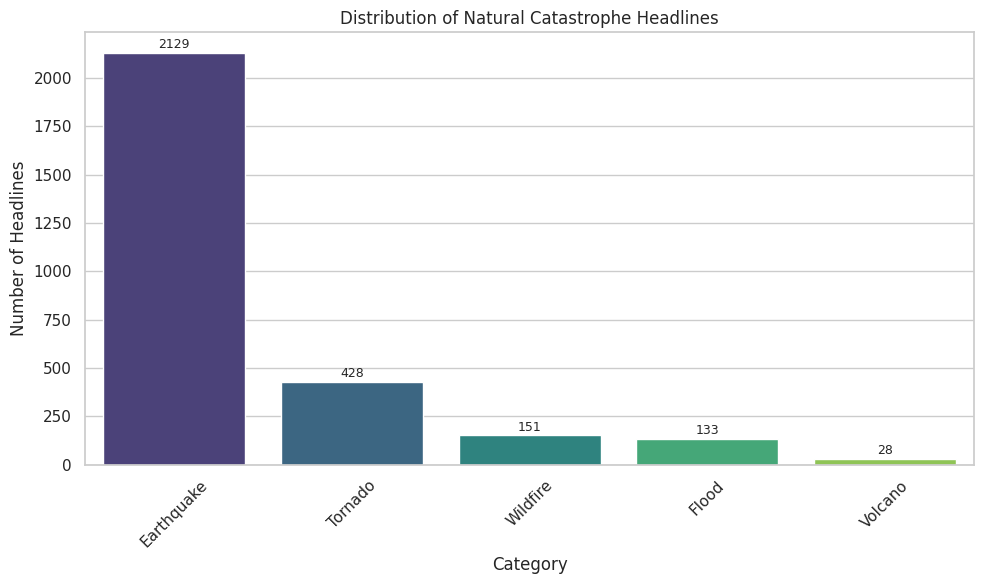

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Use your CORRECTED counts ---
category_counts = pd.Series({
    'Earthquake': 2129,
    'Tornado': 428,
    'Wildfire': 151,
    'Flood': 133,
    'Volcano': 28
})
category_counts = category_counts.sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Natural Catastrophe Headlines')
plt.xlabel('Category')
plt.ylabel('Number of Headlines')
plt.xticks(rotation=45)
for index, value in enumerate(category_counts.values):
    plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()